#### Importamos las librerías y creamos la conexión con MySQL

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Almacenamos nuestra tabla en un Dataframe

In [187]:
df_bank = pd.read_csv("perfil_cliente_mysql.csv", delimiter=";")

df_bank

,age,job,marital,education,default,balance,housing,loan
0,59,admin,married,secondary,no,2343,yes,no
1,59,admin,married,secondary,no,2343,yes,no
2,56,admin,married,secondary,no,45,no,no
3,41,technician,married,secondary,no,1270,yes,no
4,55,services,married,secondary,no,2476,yes,no
...,...,...,...,...,...,...,...,...
16158,26,admin,married,secondary,no,1595,no,no
16159,37,admin,married,secondary,no,1967,no,no
16160,45,management,married,tertiary,no,81,no,yes
16161,44,services,single,secondary,no,618,no,no


#### Vamos a convertir las categorías de trabajo en 3 subgrupos: Profesional, Manual y Otro

In [188]:
job_mapping = {
    "admin": "profesional",
    "technician": "profesional",
    "management": "profesional",
    "entrepreneur": "profesional",
    "self-employed": "profesional",
    "blue-collar": "manual",
    "services": "manual",
    "housemaid": "manual",
    "retired": "otro",
    "unemployed": "otro",
    "student": "otro",
    "unknown": "otro"
}

df_bank['job'] = df_bank['job'].replace(job_mapping)

print(df_bank['job'].value_counts())

job
profesional    9372
manual         4525
otro           2266
Name: count, dtype: int64


##### Preprocesamiento variables categóricas

In [189]:
# Selección de las columnas categóricas
categorical_features = ["job", "marital", "education", "default", "housing", "loan"]

# Instancia del OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Aplicamos el encoder a las variables categóricas
encoded_cat_data = encoder.fit_transform(df_bank[categorical_features])

# Convertir los datos codificados en un DataFrame y unirlos al original
encoded_cat_df = pd.DataFrame(encoded_cat_data, columns=encoder.get_feature_names_out(categorical_features))
df_bank = pd.concat([df_bank, encoded_cat_df], axis=1)

# Eliminar las columnas categóricas originales
df_bank.drop(categorical_features, axis=1, inplace=True)

df_bank

,age,balance,job_otro,job_profesional,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,59,2343,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,59,2343,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,56,45,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,41,1270,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,55,2476,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16158,26,1595,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16159,37,1967,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16160,45,81,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16161,44,618,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


##### Preprocesamiento variables numéricas

<Figure size 800x500 with 0 Axes>

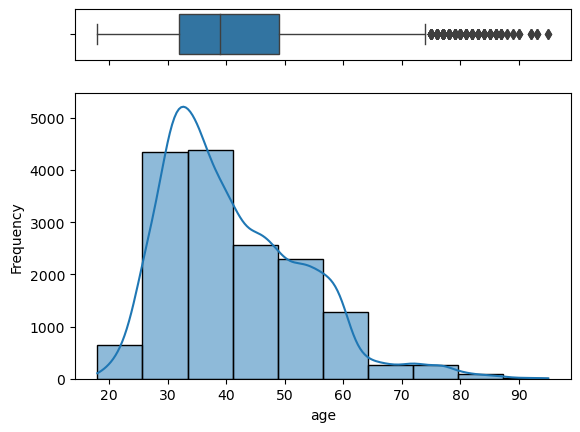

<Figure size 800x500 with 0 Axes>

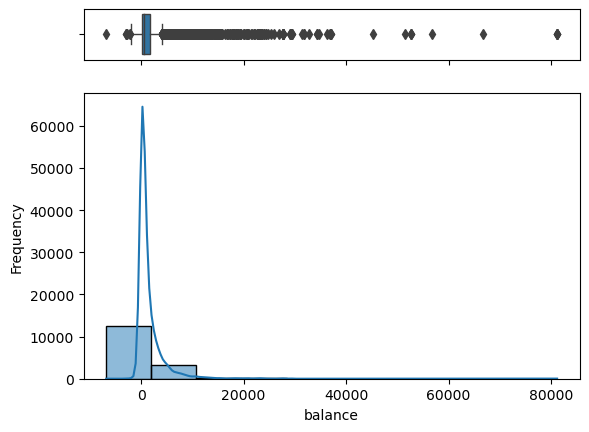

In [190]:
numerical_features = ["age", "balance"]

for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    # Crea un subplot con dos áreas (boxplot y histograma)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    # Dibuja el boxplot en la parte superior en posición horizontal
    sns.boxplot(x=df_bank[i], orient="h", ax=ax_box, linewidth=1.0)
    
    # Dibuja el histograma en la parte inferior
    sns.histplot(df_bank[i], ax=ax_hist, bins=10, kde=True)
    
    # Añade títulos a los subplots
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Como las variables tienen outliers, vamos a utilizar los límites superiores e inferiores del IQR para reemplazarlos.

In [191]:
def percentile_calculation(df, column):
    percentile_75 = df[column].quantile(0.75)
    percentile_25 = df[column].quantile(0.25)
    IQR = percentile_75 - percentile_25
    upper_limit = percentile_75 + (1.5 * IQR)
    lower_limit = percentile_25 - (1.5 * IQR)
    return upper_limit, lower_limit

def winsorize_percentile(df, column):
    upper_limit, lower_limit = percentile_calculation(df, column)
    
    # Ajustamos los valores que están fuera de los límites
    df[column] = np.where(df[column] > upper_limit, upper_limit,
                          np.where(df[column] < lower_limit, lower_limit, df[column]))
    return df


for i in numerical_features:
    df_bank = winsorize_percentile(df_bank, i)


<Figure size 800x500 with 0 Axes>

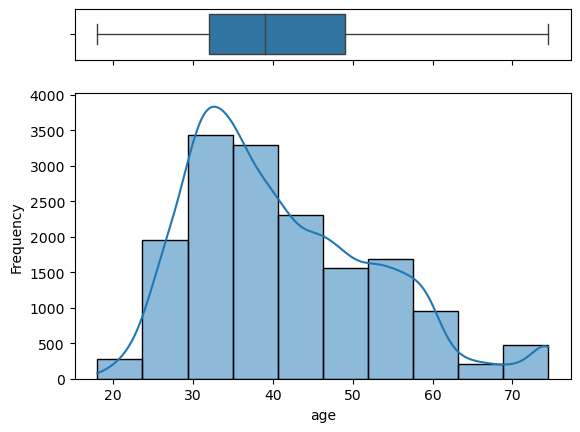

<Figure size 800x500 with 0 Axes>

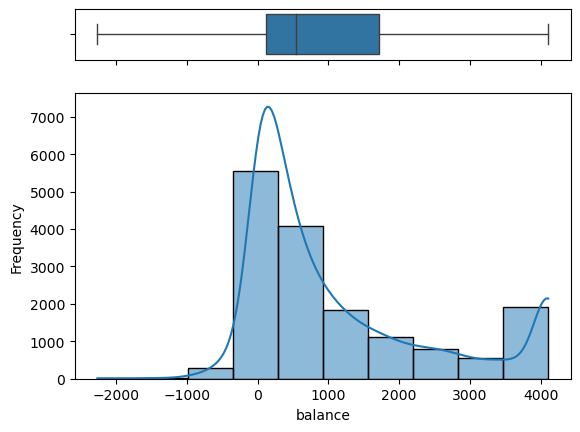

In [192]:
for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    # Crea un subplot con dos áreas (boxplot y histograma)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    # Dibuja el boxplot en la parte superior en posición horizontal
    sns.boxplot(x=df_bank[i], orient="h", ax=ax_box, linewidth=1.0)
    
    # Dibuja el histograma en la parte inferior
    sns.histplot(df_bank[i], ax=ax_hist, bins=10, kde=True)
    
    # Añade títulos a los subplots
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

In [193]:
df_bank.describe()

,age,balance,job_otro,job_profesional,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
count,16163.000000,16163.000000,16163.000000,16163.000000,16163.000000,16163.000000,16163.000000,16163.000000,16163.000000,16163.000000,16163.000000,16163.000000
mean,41.181928,1119.534987,0.140197,0.579843,0.570810,0.313370,0.490812,0.331189,0.043618,0.014911,0.472685,0.132772
std,11.695626,1355.046102,0.347202,0.493599,0.494976,0.463878,0.499931,0.470655,0.204250,0.121199,0.499269,0.339339
min,18.000000,-2268.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,543.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.000000,1717.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,74.500000,4108.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [194]:
scaler = StandardScaler()

# Aplicamos el escalado a las columnas numéricas
df_bank[numerical_features] = scaler.fit_transform(df_bank[numerical_features])

df_bank

,age,balance,job_otro,job_profesional,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,1.523529,0.902923,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.523529,0.902923,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.267015,-0.793012,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.015556,0.111044,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.181510,1.001078,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16158,-1.298126,0.350896,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16159,-0.357574,0.625434,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16160,0.326463,-0.766444,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16161,0.240958,-0.370135,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


<Figure size 800x500 with 0 Axes>

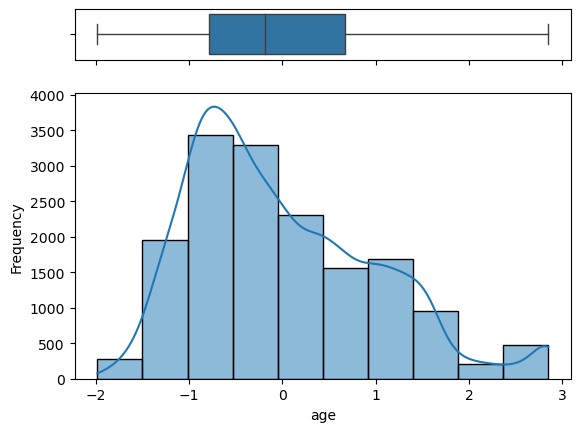

<Figure size 800x500 with 0 Axes>

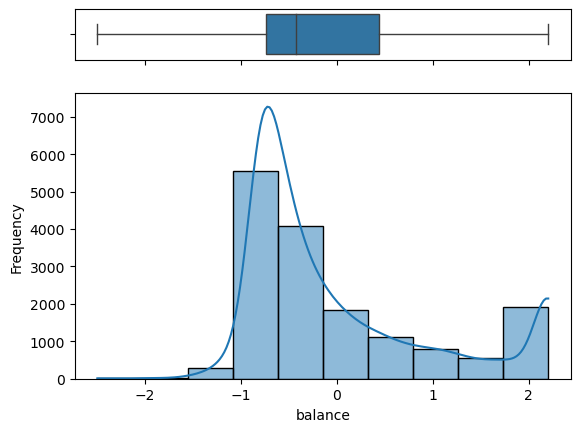

In [195]:
for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    # Crea un subplot con dos áreas (boxplot y histograma)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    # Dibuja el boxplot en la parte superior en posición horizontal
    sns.boxplot(x=df_bank[i], orient="h", ax=ax_box, linewidth=1.0)
    
    # Dibuja el histograma en la parte inferior
    sns.histplot(df_bank[i], ax=ax_hist, bins=10, kde=True)
    
    # Añade títulos a los subplots
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Identificar número de clusters

c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

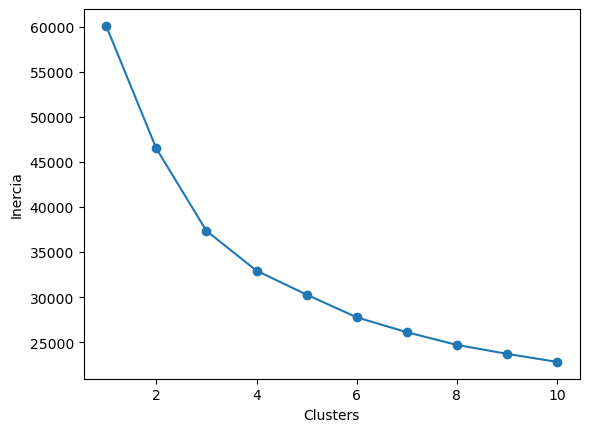

In [196]:
# Lista para almacenar la inercia para cada K
inertia = []

# Probar diferentes valores de K
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_bank)
    inertia.append(kmeans.inertia_)

# Visualizar el método del codo
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inercia')
plt.show()

#### Ejecutamos el algoritmo de K-Means con 3 clusters

In [197]:
kmeans = KMeans(n_clusters=3, random_state=42)

df_bank['cluster'] = kmeans.fit_predict(df_bank)

c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [198]:
score = silhouette_score(df_bank, df_bank['cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.29221844392957946


In [180]:
df_bank.groupby("cluster").mean()

,age,balance,job_otro,job_profesional,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
cluster,,,,,,,,,,,,
0,0.145079,1.776886,0.137580,0.638535,0.610191,0.276752,0.393949,0.421656,0.047134,0.000955,0.407962,0.061783
1,1.100050,-0.357018,0.247586,0.481782,0.777656,0.050483,0.459175,0.246488,0.068701,0.019754,0.365452,0.148156
2,-0.645727,-0.466853,0.083383,0.610842,0.444904,0.468407,0.543758,0.343215,0.028818,0.017480,0.554388,0.150821


In [21]:
print(kmeans.cluster_centers_, kmeans.inertia_)

[[ 1.03294284e-01  1.05078277e-01  1.68785311e-02  4.83121469e-01
   1.42372881e-01  4.58686441e-01]
 [ 5.42946382e-01  1.67899646e+01 -3.46944695e-18  3.18584071e-01
   3.53982301e-02  5.22123894e-01]
 [ 3.33208839e-01  3.48921451e+00  1.05820106e-03  4.03703704e-01
   6.66666667e-02  5.84656085e-01]] 36001.055820356254


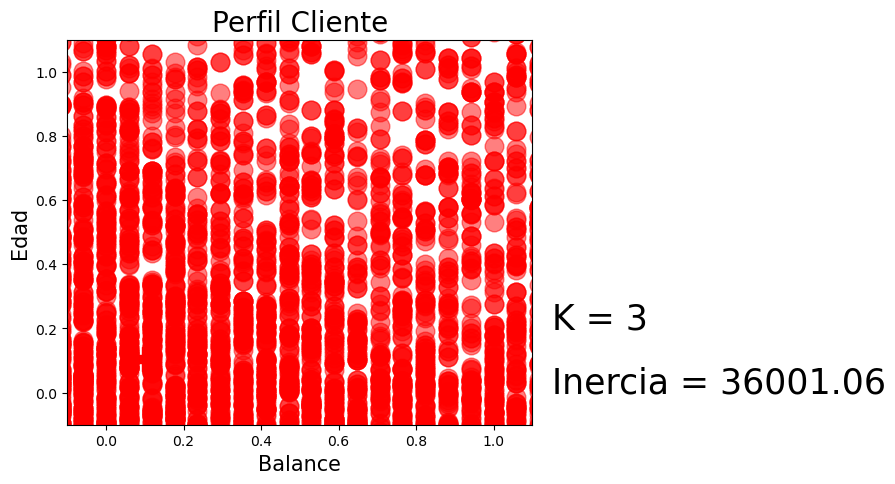

In [27]:
# Instrucciones para graficar los clusters 

plt.figure(figsize=(6, 5), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]

for cluster in range(kmeans.n_clusters):
    plt.scatter(df_bank[df_bank["cluster"] == cluster]["age"],
                df_bank[df_bank["cluster"] == cluster]["balance"],
                marker="o", s=180, color=colores[cluster], alpha=0.5)
    
    plt.scatter(kmeans.cluster_centers_[cluster][0], 
                kmeans.cluster_centers_[cluster][1], 
                marker="P", s=280, color=colores[cluster])

plt.title("Perfil Cliente", fontsize=20)
plt.xlabel("Balance", fontsize=15)
plt.ylabel("Edad", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=25)
plt.text(1.15, 0, "Inercia = %0.2f" % kmeans.inertia_, fontsize=25)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)    
plt.show()

In [134]:
medians = scaler.center_  # Mediana de cada variable
iqr = scaler.scale_        # IQR de cada variable

# Para ilustrar, supongamos que 'edad' es la primera columna y 'balance anual' la segunda
age_median, balance_median = medians[0], medians[1]
age_iqr, balance_iqr = iqr[0], iqr[1]

# Supongamos que tienes las medias estandarizadas de los clusters
cluster_means = df_kmeans.groupby('cluster')[['age', 'balance']].mean()

# Revertimos manualmente la transformación de RobustScaler
cluster_means['original_age'] = cluster_means['age'] * age_iqr + age_median
cluster_means['original_balance'] = cluster_means['balance'] * balance_iqr + balance_median

# Mostrar los resultados originales
cluster_means[['original_age', 'original_balance']]

,original_age,original_balance
cluster,,
0,44.700900,6105.052409
1,48.230088,27306.203540
2,40.751430,710.843090
